# Sleep Prediction

In this notebook we attempt to predict the specific timesteps for both sleep onsets and wakeup for each user on every night.

Much of the code in this notebook was taken and refactored to pandas from this original [notebook](https://www.kaggle.com/code/zhukovoleksiy/detect-sleep-states-baseline-solution/notebook). 

# Import Data

In [2]:
import gc
gc.collect()

0

In [3]:
# load in score function
from metric import score

# helper.py
from helper import *

In [4]:
# read in the data
root = 'data/'

# load with polars
data = pl.read_parquet(root + 'train_series_clean.parquet')
events = pl.read_csv(root + 'train_events.csv')
test = pl.read_parquet(root + 'test_series_clean.parquet')

# show number of unique series
print('Number of unique series:', data['series_id'].n_unique())

Number of unique series: 277


# Split Data

In [5]:
# get train and val subsets (28 users = 10% subset of 277 users)
data_train, data_val, events_train, events_val = train_val_split(series=data, events=events, n=28)

# check number of users in each subset
print(f'Train data series_ids: {data_train["series_id"].n_unique()}')
print(f'Val data series_ids: {data_val["series_id"].n_unique()}')

Train data series_ids: 22
Val data series_ids: 6


# Feature Engineering

In [6]:
# create features
features_train = create_features(data_train)
features_val = create_features(data_val)

# define scaler
scaler = StandardScaler()

# normalize features
features_train, scaler_fit = normalize_features(features_train, scaler, fit=True)
features_val = normalize_features(features_val, scaler_fit)

# check
features_train.sample()

Iterating through windows: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


series_id,step,anglez,enmo,date,hour,anglez_diff,enmo_diff,event,enmo_1m_mean,enmo_1m_max,enmo_1m_min,enmo_1m_std,enmo_diff_1m_mean,enmo_diff_1m_max,enmo_diff_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_min,anglez_1m_std,anglez_diff_1m_mean,anglez_diff_1m_max,anglez_diff_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_min,enmo_3m_std,enmo_diff_3m_mean,enmo_diff_3m_max,enmo_diff_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_min,anglez_3m_std,anglez_diff_3m_mean,anglez_diff_3m_max,anglez_diff_3m_std,enmo_5m_mean,enmo_5m_max,enmo_5m_min,enmo_5m_std,enmo_diff_5m_mean,enmo_diff_5m_max,enmo_diff_5m_std,anglez_5m_mean,anglez_5m_max,anglez_5m_min,anglez_5m_std,anglez_diff_5m_mean,anglez_diff_5m_max,anglez_diff_5m_std,enmo_7.5m_mean,enmo_7.5m_max,enmo_7.5m_min,enmo_7.5m_std,enmo_diff_7.5m_mean,enmo_diff_7.5m_max,enmo_diff_7.5m_std,anglez_7.5m_mean,anglez_7.5m_max,anglez_7.5m_min,anglez_7.5m_std,anglez_diff_7.5m_mean,anglez_diff_7.5m_max,anglez_diff_7.5m_std,enmo_10m_mean,enmo_10m_max,enmo_10m_min,enmo_10m_std,enmo_diff_10m_mean,enmo_diff_10m_max,enmo_diff_10m_std,anglez_10m_mean,anglez_10m_max,anglez_10m_min,anglez_10m_std,anglez_diff_10m_mean,anglez_diff_10m_max,anglez_diff_10m_std,enmo_12.5m_mean,enmo_12.5m_max,enmo_12.5m_min,enmo_12.5m_std,enmo_diff_12.5m_mean,enmo_diff_12.5m_max,enmo_diff_12.5m_std,anglez_12.5m_mean,anglez_12.5m_max,anglez_12.5m_min,anglez_12.5m_std,anglez_diff_12.5m_mean,anglez_diff_12.5m_max,anglez_diff_12.5m_std,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diff_15m_mean,enmo_diff_15m_max,enmo_diff_15m_std,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diff_15m_mean,anglez_diff_15m_max,anglez_diff_15m_std,enmo_20m_mean,enmo_20m_max,enmo_20m_min,enmo_20m_std,enmo_diff_20m_mean,enmo_diff_20m_max,enmo_diff_20m_std,anglez_20m_mean,anglez_20m_max,anglez_20m_min,anglez_20m_std,anglez_diff_20m_mean,anglez_diff_20m_max,anglez_diff_20m_std,enmo_25m_mean,enmo_25m_max,enmo_25m_min,enmo_25m_std,enmo_diff_25m_mean,enmo_diff_25m_max,enmo_diff_25m_std,anglez_25m_mean,anglez_25m_max,anglez_25m_min,anglez_25m_std,anglez_diff_25m_mean,anglez_diff_25m_max,anglez_diff_25m_std,enmo_30m_mean,enmo_30m_max,enmo_30m_min,enmo_30m_std,enmo_diff_30m_mean,enmo_diff_30m_max,enmo_diff_30m_std,anglez_30m_mean,anglez_30m_max,anglez_30m_min,anglez_30m_std,anglez_diff_30m_mean,anglez_diff_30m_max,anglez_diff_30m_std,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diff_60m_mean,enmo_diff_60m_max,enmo_diff_60m_std,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diff_60m_mean,anglez_diff_60m_max,anglez_diff_60m_std,enmo_120m_mean,enmo_120m_max,enmo_120m_min,enmo_120m_std,enmo_diff_120m_mean,enmo_diff_120m_max,enmo_diff_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_min,anglez_120m_std,anglez_diff_120m_mean,anglez_diff_120m_max,anglez_diff_120m_std,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diff_180m_mean,enmo_diff_180m_max,enmo_diff_180m_std,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diff_180m_mean,anglez_diff_180m_max,anglez_diff_180m_std,enmo_240m_mean,enmo_240m_max,enmo_240m_min,enmo_240m_std,enmo_diff_240m_mean,enmo_diff_240m_max,enmo_diff_240m_std,anglez_240m_mean,anglez_240m_max,anglez_240m_min,anglez_240m_std,anglez_diff_240m_mean,anglez_diff_240m_max,anglez_diff_240m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diff_480m_mean,enmo_diff_480m_max,enmo_diff_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diff_480m_mean,anglez_diff_480m_max,anglez_diff_480m_std
str,u32,f32,f32,date,i8,f32,f32,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f

- 4 id cols + __215__ features.

In [7]:
# define x and y
X_train, y_train = make_train_dataset(features_train)
X_val, y_val = make_train_dataset(features_val)

# check shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

processing users: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

X_train shape: (9661500, 219)
y_train shape: (9661500,)
X_val shape: (2559060, 219)
y_val shape: (2559060,)


In [8]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

# XGBoost

              precision    recall  f1-score   support

           0       0.99      0.97      0.98   1846716
           1       0.92      0.96      0.94    712344

    accuracy                           0.97   2559060
   macro avg       0.95      0.96      0.96   2559060
weighted avg       0.97      0.97      0.97   2559060



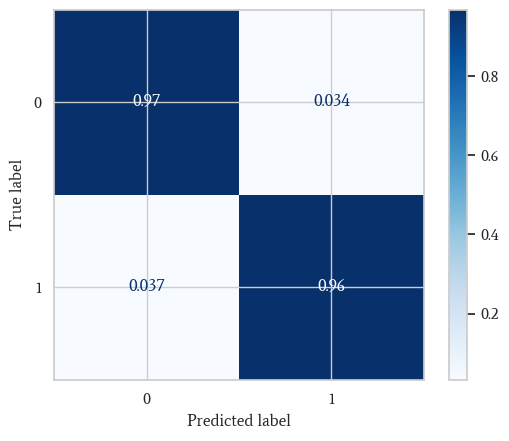

In [ ]:
# define non-feature cols
non_feat_cols = ['series_id', 'step', 'date', 'event']

# create xgb and fit
xgb = XGBClassifier(random_state=SEED, n_jobs=-1)
xgb.fit(X_train.drop(non_feat_cols), y_train)

# get train and val preds
train_preds = xgb.predict(X_train.drop(non_feat_cols))
val_preds = xgb.predict(X_val.drop(non_feat_cols))

# validation performance
print(classification_report(y_val, val_preds))
ConfusionMatrixDisplay.from_predictions(y_val, val_preds, normalize='true', cmap='Blues');

- Got about __97% accuracy on the 10% subset__ using a base XGBoost model. Now, we will use RandomizedSearchCV to hypertune a model, in hopes to beat this benchmark score.

# Hyperparameter Search

In [ ]:
def xgb_cv(max_depth, n_estimators, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, X, y, series_ids):
    """
    Objective function for XGBoost hyperparameter tuning using Bayesian Optimization.

    Args:
    - XGBClassifier parameters: max_depth, n_estimators, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode
    - X (pd.DataFrame): Feature set.
    - y (pd.Series): Target variable.
    - series_ids (list): List of unique series IDs. Passed into function to minimize extra computation.

    Returns:
    """

    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bynode': colsample_bynode,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'device': 'cuda',
        'tree_method': 'hist',
        'random_state': SEED 
    }

    # define model
    model = XGBClassifier(**params)

    # 80/20 split on 10% of all series_ids
    train_ids = np.random.choice(series_ids, 22, replace=False)
    remaining_ids = [sid for sid in series_ids if sid not in train_ids]
    val_ids = np.random.choice(remaining_ids, 6, replace=False)

    # create train and val data
    features_train = X.filter(pl.col("series_id").is_in(train_ids))
    features_val = X.filter(pl.col("series_id").is_in(val_ids))

    # define scaler
    scaler = StandardScaler()

    # normalize features
    features_train, scaler_fit = normalize_features(features_train, scaler, fit=True)
    features_val = normalize_features(features_val, scaler_fit)

In [ ]:
# create features for entire dataset
features = create_features(data)

# define x and y
X, y = make_train_dataset(features)

# get unique series ids
series_ids = features.select("series_id").unique().to_series().to_list()

# define the parameter search space
param_bounds = {'max_depth': (3, 10), 'n_estimators': (100, 1000), 'learning_rate': (0.001, 0.1), 'gamma': (0, 0.5), 'min_child_weight': (1, 10), 'subsample': (0.5, 1.0)}

# run bayesian optimization
optimizer = BayesianOptimization(f=lambda max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode: 
            xgb_cv(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, X, y, series_ids),
            pbounds=param_bounds,
            random_state=SEED,
            verbose=2)

# optimize for 100 iterations
optimizer.maximize(init_points=10, n_iter=90)

# Prediction Errors
We'll use the 'score' function from [metric.py](metric.py).

In [ ]:
def predict(data, classifier):
    """
    Takes a time series of (containing features and labels) and a classifier and returns a formatted submission dataframe.

    Args:
    - data: Polars DataFrame containing series data and sleep events
    - classifier: trained classifier

    Returns:
    - event_preds_df: Pandas DataFrame containing predicted sleep events
    """
    
    # define columns: string columns and feature columns
    str_cols = ['series_id', 'step', 'date', 'event']
    feature_cols = [col for col in data.columns if col not in str_cols]

    # get unique series_ids as a list
    series_ids = data.select("series_id").unique().to_series().to_list()

    # precompute global std for each feature column (used for normalization)
    std_dict = {}
    for col in feature_cols:
        # compute std from the entire series
        std_val = data.select(pl.col(col)).std().item()
        std_dict[col] = std_val

    # list to accumulate event predictions
    event_preds = []

    for sid in tqdm(series_ids, desc="Iterating through series_ids"):
        # filter the data for the current series id
        X = data.filter(pl.col("series_id") == sid)
        
        # columns to scale: ignore 'hour' and those with a global std of zero
        scaled_cols = [col for col in feature_cols if (col != 'hour' and std_dict.get(col, 0) != 0)]
        
        # normalize using global standard deviation
        for col in scaled_cols:
            std_val = std_dict[col]
            X = X.with_columns((pl.col(col) / std_val).alias(col))
        
        # convert the feature columns to a pd.DataFrame for the classifier
        X_pd = X.select(feature_cols).to_pandas()
        
        # get preds
        preds = classifier.predict(X_pd)
        probs = classifier.predict_proba(X_pd)[:, 1]
        
        # append predictions to X
        X = X.with_columns([pl.Series("pred", preds), pl.Series("prob", probs)])
        
        # calculate the difference in predictions to find changes
        X = X.with_columns(pl.col("pred").diff().alias("pred_diff"))
        
        # extract the 'step' values where the change indicates an onset (0 -> 1) or wakeup (1 -> 0)
        pred_onsets = X.filter(pl.col("pred_diff") > 0)["step"].to_list()
        pred_wakeups = X.filter(pl.col("pred_diff") < 0)["step"].to_list()
        
        # process events if we have at least one onset and wakeup
        if len(pred_onsets) > 0 and len(pred_wakeups) > 0:
            # if first wakeup occurs before the first onset, drop it
            if pred_wakeups[0] < pred_onsets[0]:
                pred_wakeups = pred_wakeups[1:]
            # if last onset occurs after the last wakeup, drop it
            if pred_onsets and pred_wakeups and pred_onsets[-1] > pred_wakeups[-1]:
                pred_onsets = pred_onsets[:-1]
            
            # create sleep periods only if the duration is at least 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if (wakeup - onset) >= (120 * 12)]

            # # prune multiple sleep periods in the same 8-hr window
            # window = 8 * 60 * 12
            # pruned_sleep_periods = []
            # for onset, wakeup in sorted(sleep_periods, key=lambda x: x[0]):
            #     # if there's no period yet, add the current one
            #     if not pruned_sleep_periods:
            #         pruned_sleep_periods.append((onset, wakeup))
            #     else:
            #         last_onset, last_wakeup = pruned_sleep_periods[-1]
            #         # if the current onset is within the window of the last added onset, keep the one with longer duration
            #         if onset - last_onset < window:
            #             current_duration = wakeup - onset
            #             last_duration = last_wakeup - last_onset
            #             if current_duration > last_duration:
            #                 # replace the last period with the current one
            #                 pruned_sleep_periods[-1] = (onset, wakeup)
            #         else:
            #             # no conflict, add the current period
            #             pruned_sleep_periods.append((onset, wakeup))
            
            # iterate through sleep periods
            for onset, wakeup in sleep_periods:
                # compute the average probability score
                sleep_segment = X.filter((pl.col("step") >= onset) & (pl.col("step") < wakeup))
                score = sleep_segment.select(pl.col("prob")).mean().item()
                
                # get onset and wakeup dates
                onset_date = X.filter(pl.col("step") == onset).select(pl.col("date")).to_series()[0]
                wakeup_date = X.filter(pl.col("step") == wakeup).select(pl.col("date")).to_series()[0]
                
                # append the events to the list
                event_preds.append({"series_id": sid, "step": onset, "event": "onset", "score": score, "date": onset_date})
                event_preds.append({"series_id": sid, "step": wakeup, "event": "wakeup", "score": score, "date": wakeup_date})

    # create a pandas df for the preds
    event_preds_df = pd.DataFrame(event_preds)

    # add 'row_id' col
    event_preds_df['row_id'] = range(len(event_preds_df))

    return event_preds_df

In [5]:
X_val.sample()

series_id,step,date,hour,event,anglez,enmo,anglez_diff,enmo_diff,enmo_1m_mean,enmo_1m_max,enmo_1m_min,enmo_1m_std,enmo_diff_1m_mean,enmo_diff_1m_max,enmo_diff_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_min,anglez_1m_std,anglez_diff_1m_mean,anglez_diff_1m_max,anglez_diff_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_min,enmo_3m_std,enmo_diff_3m_mean,enmo_diff_3m_max,enmo_diff_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_min,anglez_3m_std,anglez_diff_3m_mean,anglez_diff_3m_max,anglez_diff_3m_std,enmo_5m_mean,enmo_5m_max,enmo_5m_min,enmo_5m_std,enmo_diff_5m_mean,enmo_diff_5m_max,enmo_diff_5m_std,anglez_5m_mean,anglez_5m_max,anglez_5m_min,anglez_5m_std,anglez_diff_5m_mean,anglez_diff_5m_max,anglez_diff_5m_std,enmo_7.5m_mean,enmo_7.5m_max,enmo_7.5m_min,enmo_7.5m_std,enmo_diff_7.5m_mean,enmo_diff_7.5m_max,enmo_diff_7.5m_std,anglez_7.5m_mean,anglez_7.5m_max,anglez_7.5m_min,anglez_7.5m_std,anglez_diff_7.5m_mean,anglez_diff_7.5m_max,anglez_diff_7.5m_std,enmo_10m_mean,enmo_10m_max,enmo_10m_min,enmo_10m_std,enmo_diff_10m_mean,enmo_diff_10m_max,enmo_diff_10m_std,anglez_10m_mean,anglez_10m_max,anglez_10m_min,anglez_10m_std,anglez_diff_10m_mean,anglez_diff_10m_max,anglez_diff_10m_std,enmo_12.5m_mean,enmo_12.5m_max,enmo_12.5m_min,enmo_12.5m_std,enmo_diff_12.5m_mean,enmo_diff_12.5m_max,enmo_diff_12.5m_std,anglez_12.5m_mean,anglez_12.5m_max,anglez_12.5m_min,anglez_12.5m_std,anglez_diff_12.5m_mean,anglez_diff_12.5m_max,anglez_diff_12.5m_std,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diff_15m_mean,enmo_diff_15m_max,enmo_diff_15m_std,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diff_15m_mean,anglez_diff_15m_max,anglez_diff_15m_std,enmo_20m_mean,enmo_20m_max,enmo_20m_min,enmo_20m_std,enmo_diff_20m_mean,enmo_diff_20m_max,enmo_diff_20m_std,anglez_20m_mean,anglez_20m_max,anglez_20m_min,anglez_20m_std,anglez_diff_20m_mean,anglez_diff_20m_max,anglez_diff_20m_std,enmo_25m_mean,enmo_25m_max,enmo_25m_min,enmo_25m_std,enmo_diff_25m_mean,enmo_diff_25m_max,enmo_diff_25m_std,anglez_25m_mean,anglez_25m_max,anglez_25m_min,anglez_25m_std,anglez_diff_25m_mean,anglez_diff_25m_max,anglez_diff_25m_std,enmo_30m_mean,enmo_30m_max,enmo_30m_min,enmo_30m_std,enmo_diff_30m_mean,enmo_diff_30m_max,enmo_diff_30m_std,anglez_30m_mean,anglez_30m_max,anglez_30m_min,anglez_30m_std,anglez_diff_30m_mean,anglez_diff_30m_max,anglez_diff_30m_std,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diff_60m_mean,enmo_diff_60m_max,enmo_diff_60m_std,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diff_60m_mean,anglez_diff_60m_max,anglez_diff_60m_std,enmo_120m_mean,enmo_120m_max,enmo_120m_min,enmo_120m_std,enmo_diff_120m_mean,enmo_diff_120m_max,enmo_diff_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_min,anglez_120m_std,anglez_diff_120m_mean,anglez_diff_120m_max,anglez_diff_120m_std,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diff_180m_mean,enmo_diff_180m_max,enmo_diff_180m_std,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diff_180m_mean,anglez_diff_180m_max,anglez_diff_180m_std,enmo_240m_mean,enmo_240m_max,enmo_240m_min,enmo_240m_std,enmo_diff_240m_mean,enmo_diff_240m_max,enmo_diff_240m_std,anglez_240m_mean,anglez_240m_max,anglez_240m_min,anglez_240m_std,anglez_diff_240m_mean,anglez_diff_240m_max,anglez_diff_240m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diff_480m_mean,enmo_diff_480m_max,enmo_diff_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diff_480m_mean,anglez_diff_480m_max,anglez_diff_480m_std
str,u32,date,i8,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f

In [8]:
# get predictions
val_preds = val_predict(X_val, logreg)
val_preds

Iterating through series_ids: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


,series_id,step,event,score,date,row_id
0,def21f50dd3c,7380,onset,0.585032,2017-08-16,0
1,def21f50dd3c,7804,wakeup,0.585032,2017-08-16,1
2,def21f50dd3c,10402,onset,0.616809,2017-08-16,2
3,def21f50dd3c,10798,wakeup,0.616809,2017-08-16,3
4,def21f50dd3c,24612,onset,0.705691,2017-08-16,4
...,...,...,...,...,...,...
427,6a4cd123bd69,511227,wakeup,0.755315,2018-05-17,427
428,6a4cd123bd69,511240,onset,0.779797,2018-05-17,428
429,6a4cd123bd69,512927,wakeup,0.779797,2018-05-17,429
430,6a4cd123bd69,512928,onset,0.661794,2018-05-17,430


In [20]:
# get predictions
val_preds = predict(X_val, logreg)

# get labels for validation set
val_labels = events.filter(pl.col('series_id').is_in(data_val.select(pl.col('series_id')).unique())).select(['series_id', 'step', 'event']).to_pandas()

# args for scoring function
tolerances = {"onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
              "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

# get score
val_score = score(solution=val_labels, submission=val_preds, tolerances=tolerances, 
      series_id_column_name='series_id', time_column_name='step', event_column_name='event', score_column_name='score')

# check score
val_score

Iterating through series_ids: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


0.03360485705040511

- Very poor score of 0.19 (perfect score is 1.0). Let's visualize to see why our predictions were scored so poorly.

# Visualize Predictions
Look at where our model is predicting onset and wakeup and compare to the true labels.

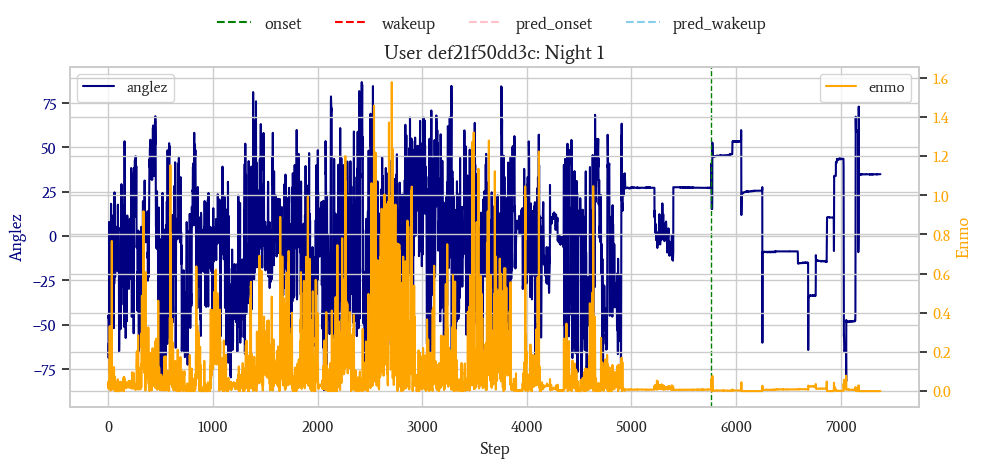

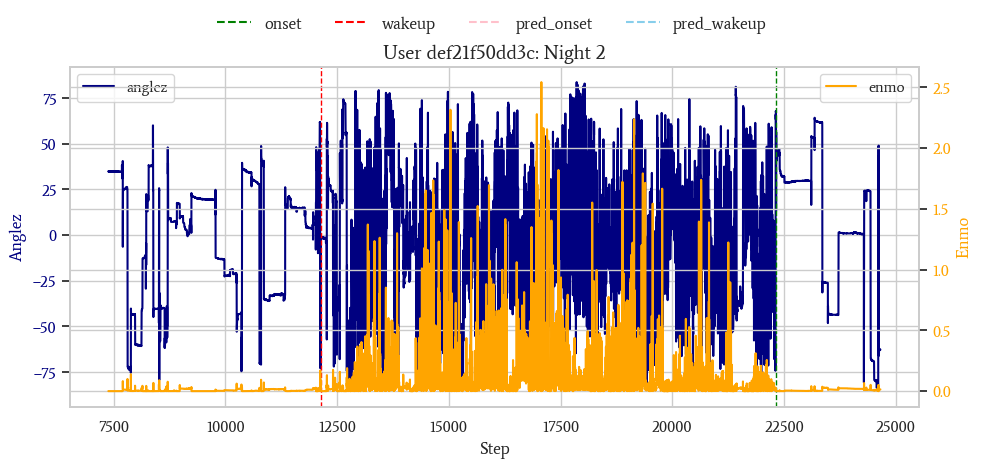

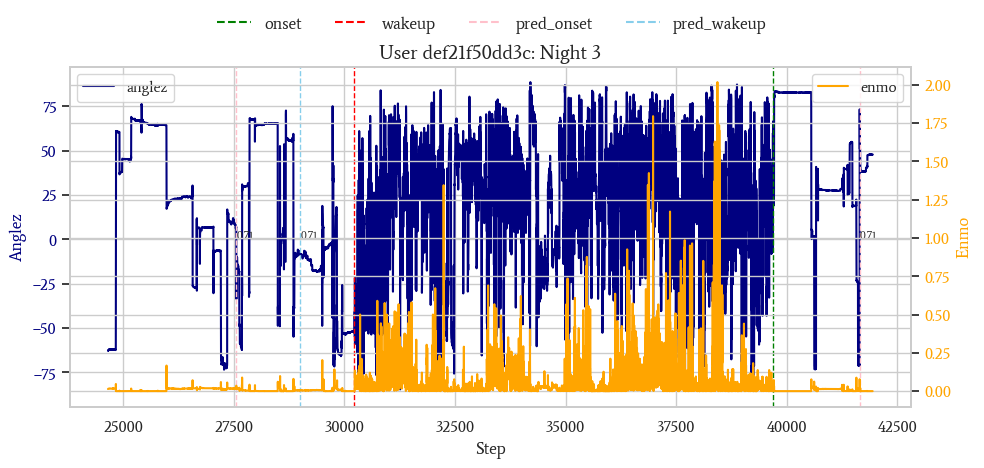

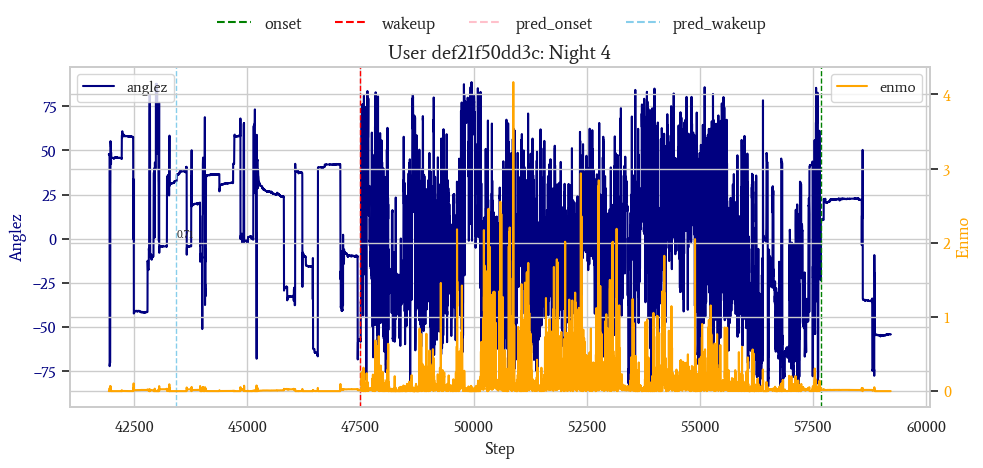

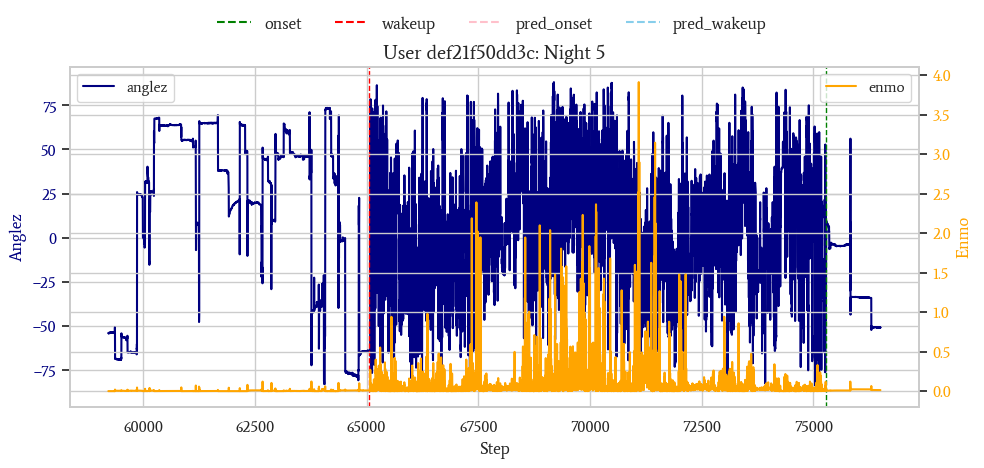

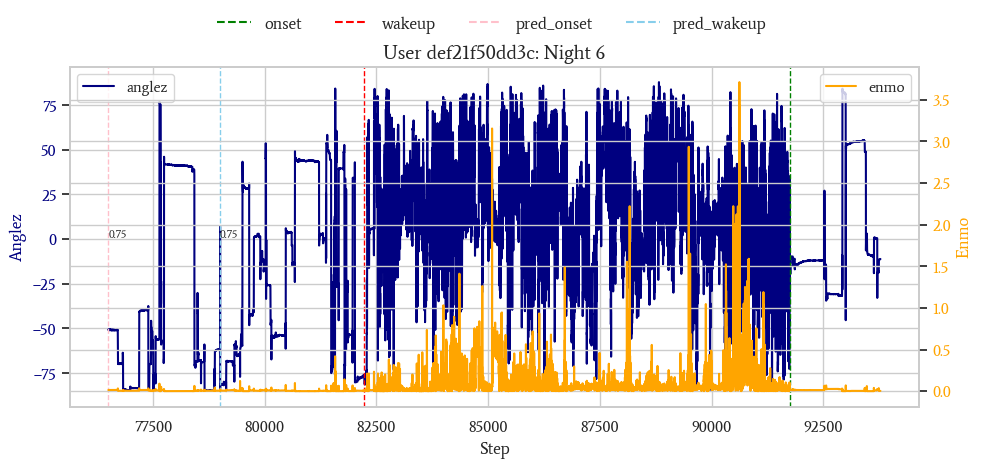

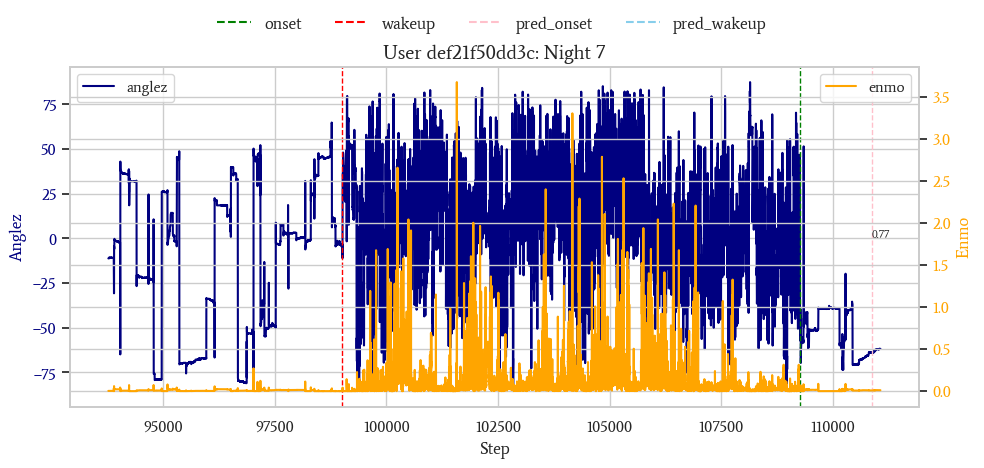

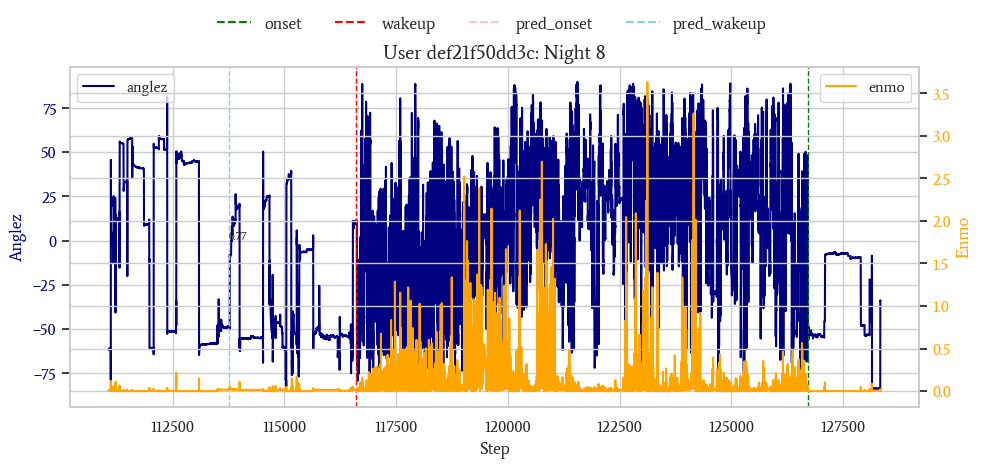

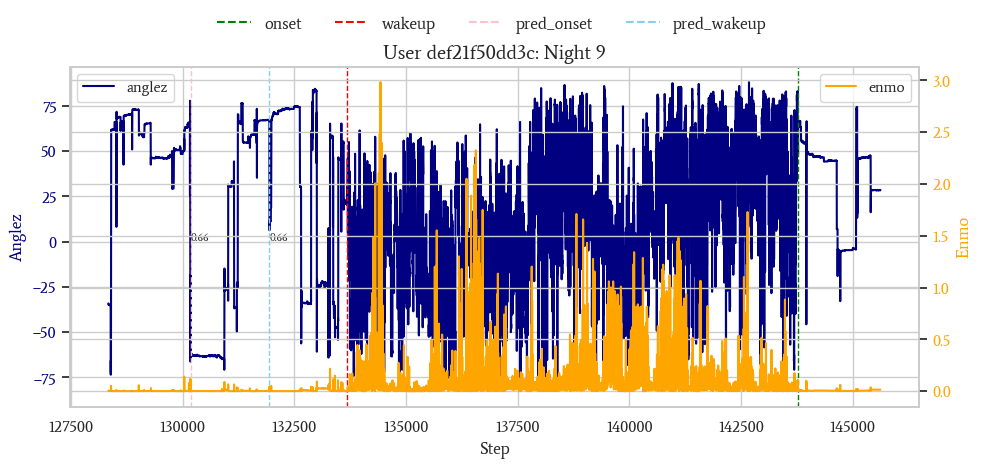

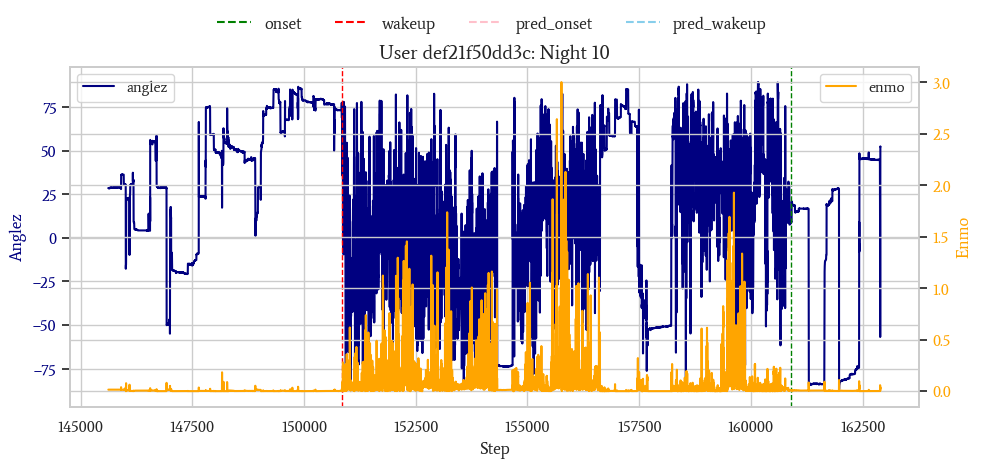

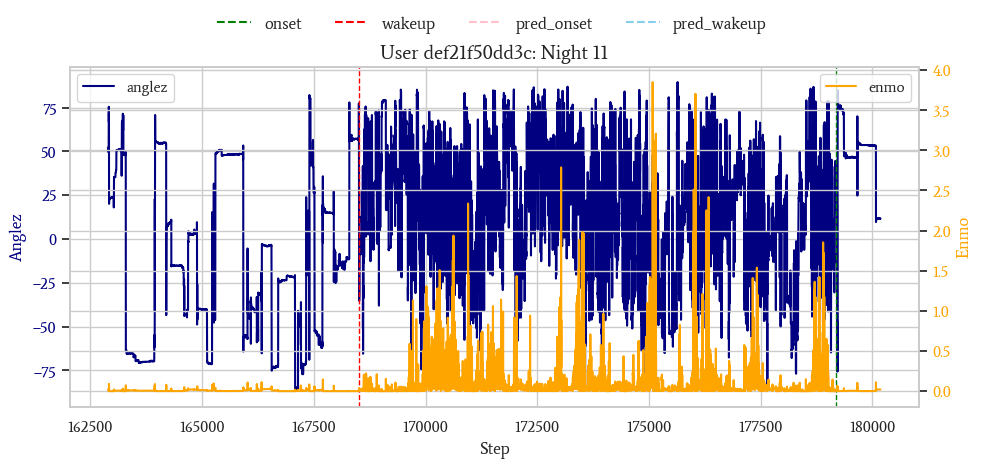

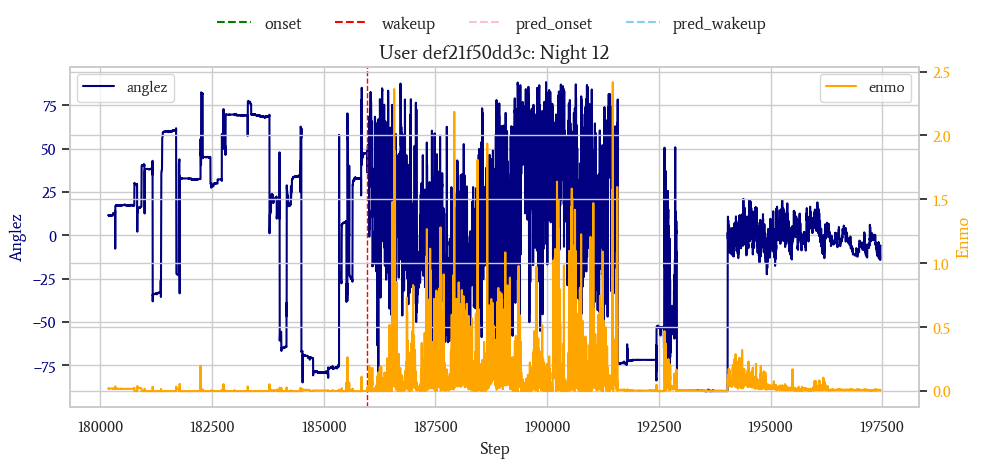

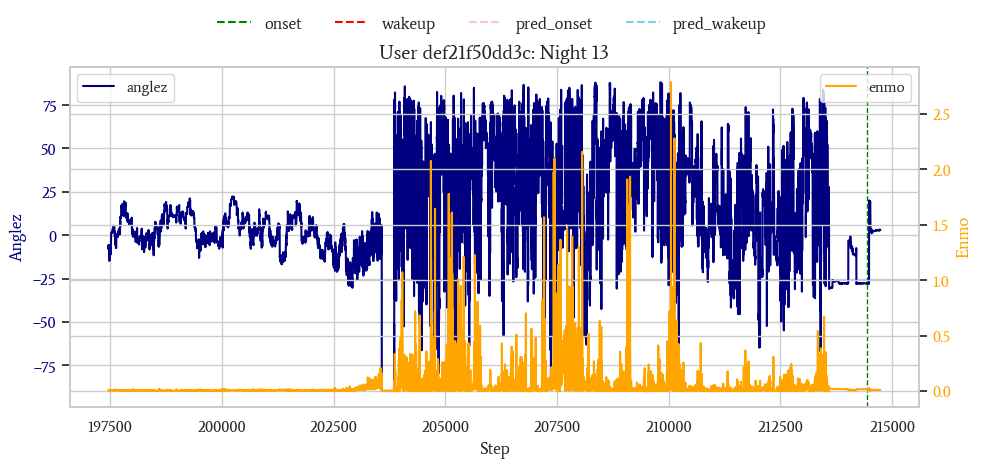

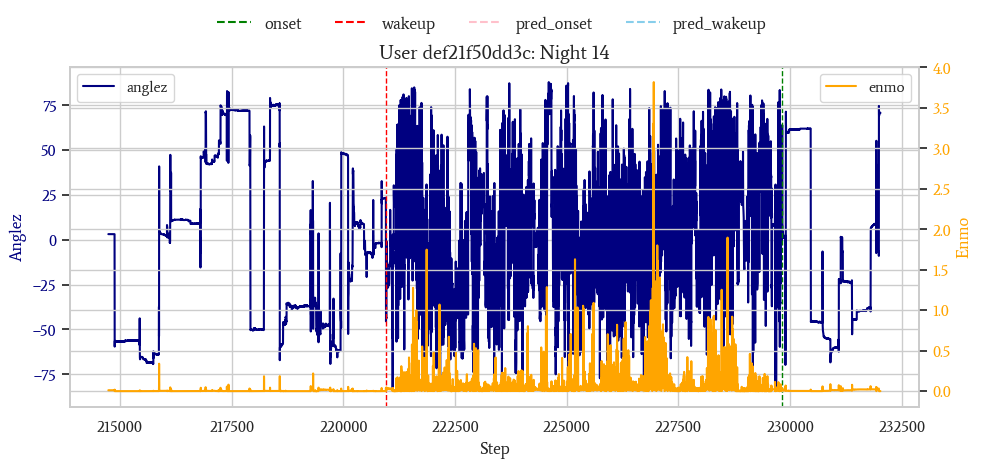

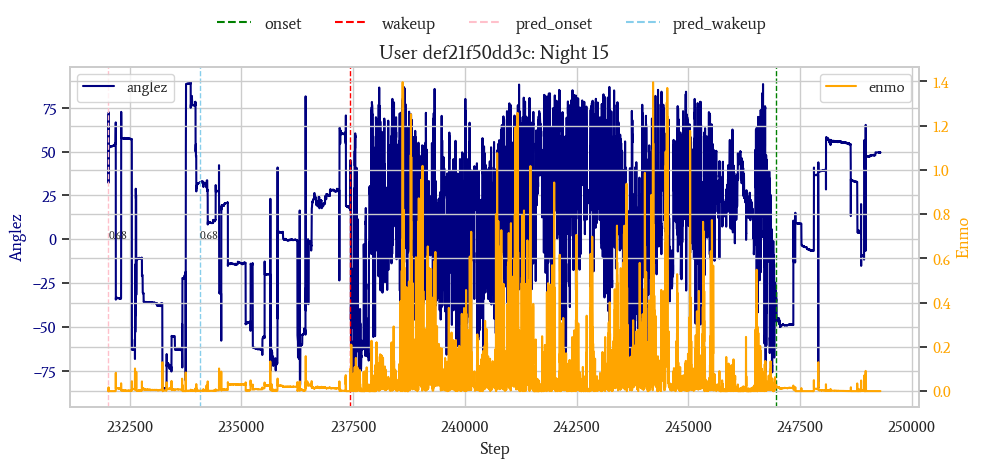

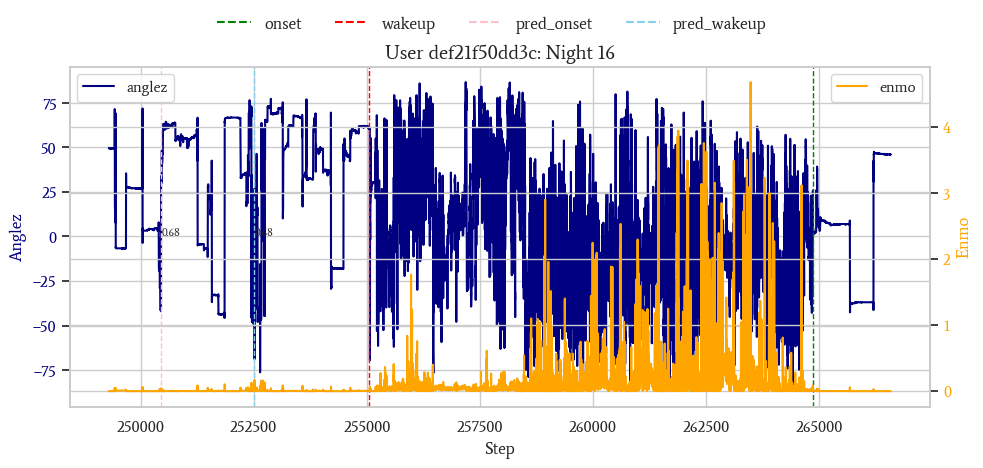

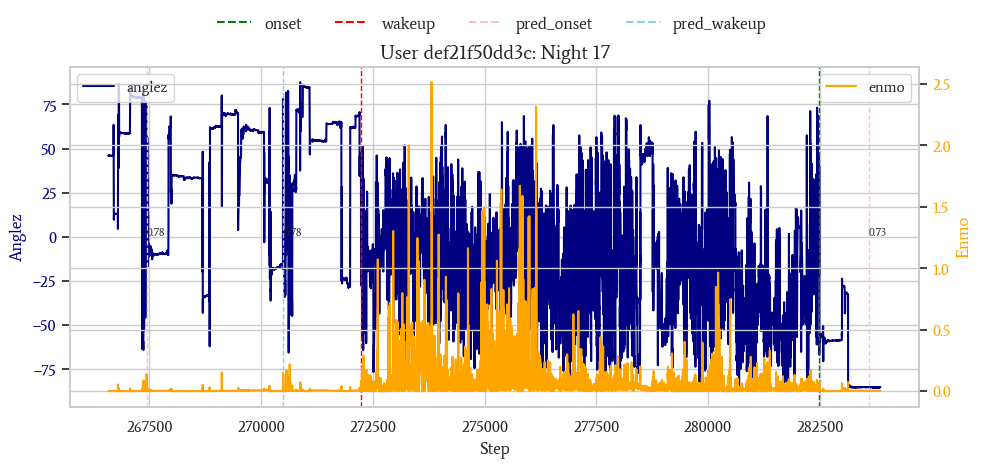

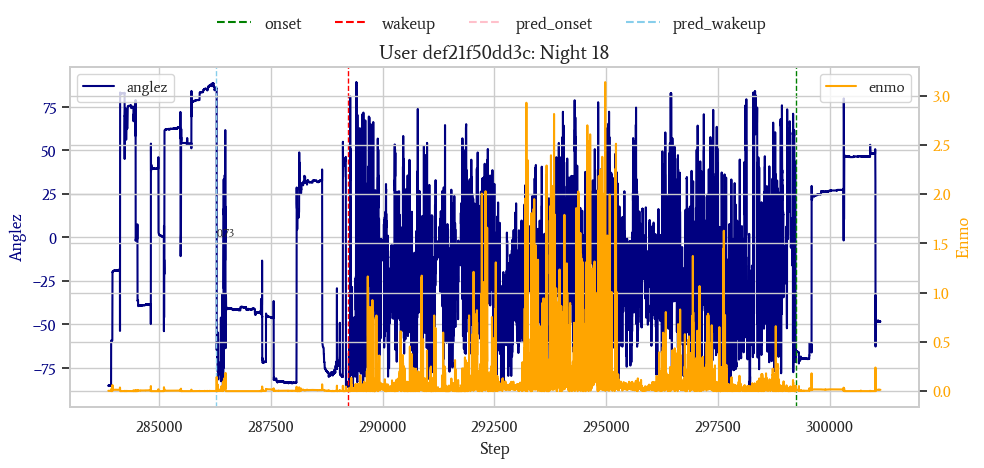

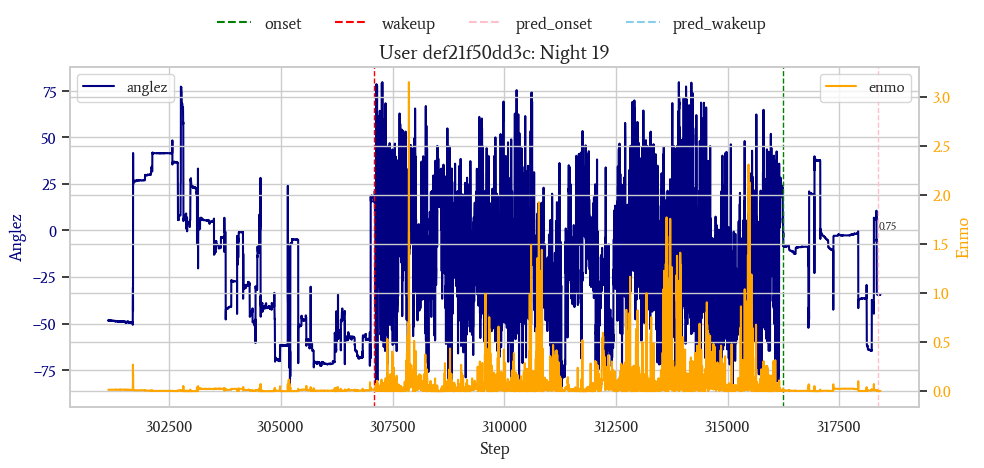

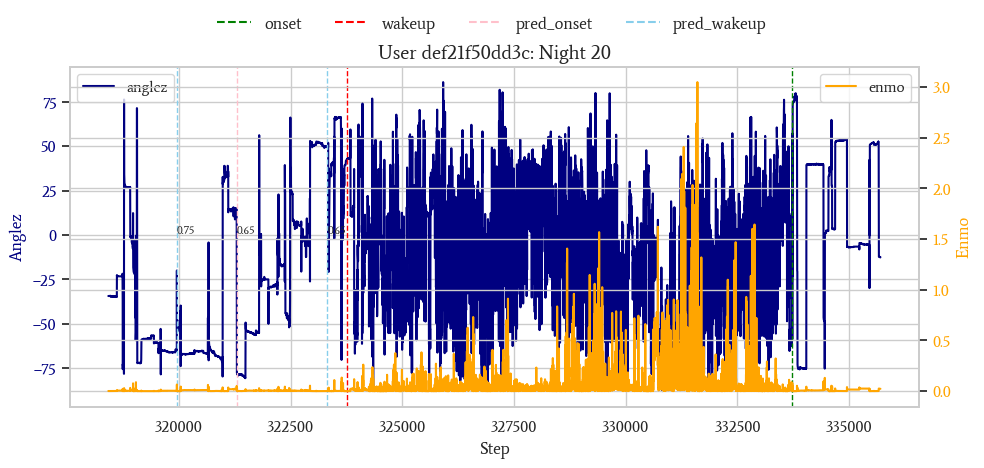

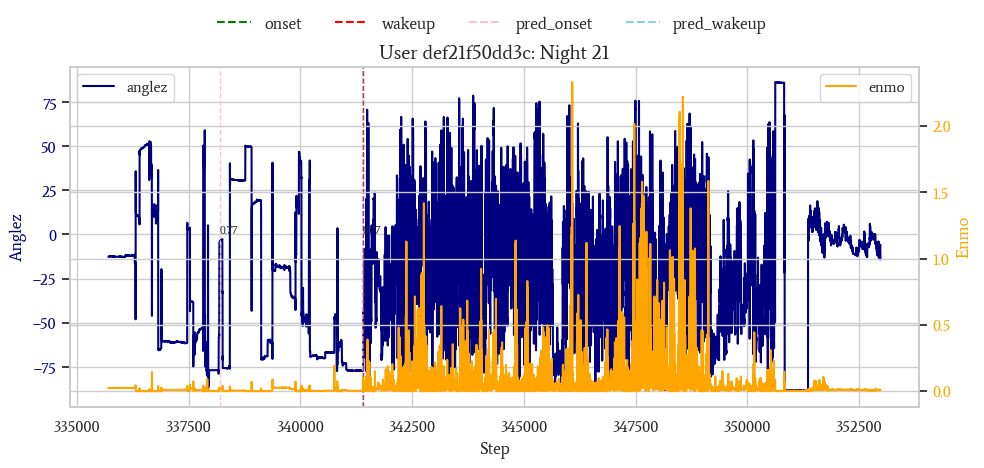

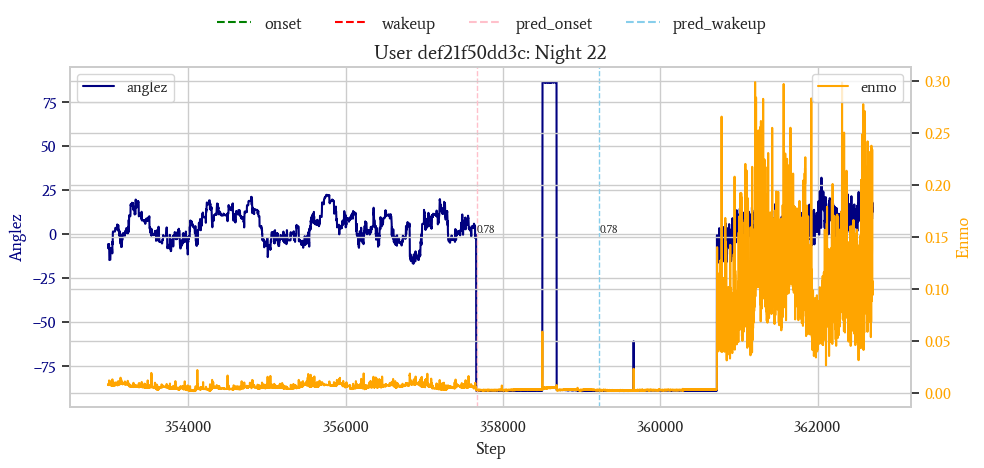

In [21]:
# get a random user
user_id = get_random_id(data_val)

# get data, preds, and events for the user
user_data = data_val.filter(pl.col('series_id') == user_id)
user_preds = val_preds.query('series_id == @user_id')
user_events = events.filter(pl.col('series_id') == user_id)

# plot preds
plot_preds(user_data, user_preds, user_events)

In this original implementation, our model has a propensity to predict many onsets/wakeups in a single night (instead of 1 each). We 

# Train Final Model

In [ ]:
# create features for entire dataset
features = create_features(data)

# define x and y
X_train, y_train = make_train_dataset(features)

# fit scaler
scaler = StandardScaler()
scaler.fit(X_train[norm_cols])

# normalize features
X_train = normalize_features(X_train, scaler)

# init best model, fit on entire training set
model = None
model.fit(X_train.drop(non_norm_cols), y_train)

# get predictions
preds = predict(X_train.drop(non_norm_cols), model)

# view final score
val_score = score(solution=events.select(['series_id', 'step', 'event']).to_pandas(), submission=preds, tolerances=tolerances, 
      series_id_column_name='series_id', time_column_name='step', event_column_name='event', score_column_name='score')
val_score

- A final score of 

# Submission

In [ ]:
# create features for test set
X_test = create_features(test)

# fit scaler
scaler = StandardScaler()
scaler.fit(X_test[norm_cols])

# normalize features
X_test = normalize_features(X_test, scaler)

# get predictions
preds = predict(X_test.drop(non_norm_cols[:-1]), model)

In [ ]:

submission.drop('date', axis=1).to_csv('submission.csv', index=False)